50


/tmp/ipykernel_511388/1981637717.py:54: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
/data/hulab/zcai75/anaconda3/envs/vilt/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


2343171


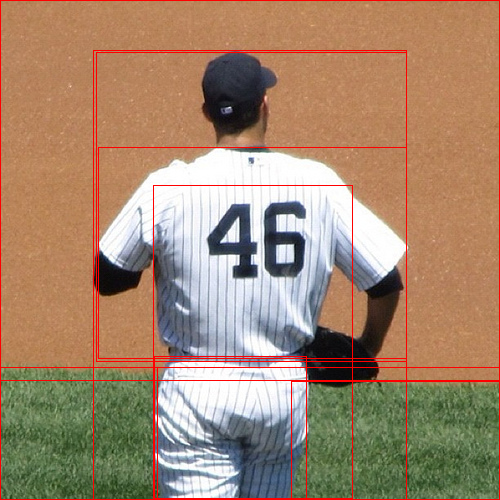

[['surfboard', 'under', 'arm arm arm arm arm'], ['wheel', 'on', 'on'], ['wheel', 'on', 'on'], ['wheel', 'on', 'on'], ['surfboard', 'under', 'arm arm arm arm arm'], ['wheel', 'on', 'on'], ['wheel', 'on', 'on']]
[['head', 'of', 'person'], ['arm', 'of', 'person'], ['arm', 'of', 'person'], ['arm', 'of', 'player'], ['glove', 'on', 'hand']]


/home/zcai75/Github/OFA/fairseq/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/zcai75/Github/OFA_forked/models/sequence_generator.py:705: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


ValueError: not enough values to unpack (expected 3, got 1)

<Figure size 500x4500 with 0 Axes>

In [3]:
import json 
from tqdm import tqdm
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

with open('results/vrd/test_predict_0.006044012152175453.json') as f:
    results = json.load(f)

pred_strs = list(results[0]['pred_count'].keys())
print(len(pred_strs))
import torch
import numpy as np
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from tasks.mm_tasks.vrd2 import VRD2Task

from models.ofa import OFAModel
from PIL import Image

tasks.register_task('vrd2', VRD2Task)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

torch.cuda.set_device(3)
# specify some options for evaluation
# Load pretrained ckpt & config
overrides={"eval_cider":False, "beam":5, "no_repeat_ngram_size": 3, "seed":13, "min_len": 1, "bpe_dir": "utils/BPE"}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/OFA/vrd2_checkpoints/_16_3e-5_512/checkpoint4.pt'),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)
# Image transform
import PIL
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()


def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(toks, task):
    s = task.tgt_dict.string(toks.int().cpu())
    return s


def coord2bin(coord_list, box_size, w, h, max_img_size, num_bins):
    # coord / box_size(1024) * max_img_size / w_or_h
	bin_list = []
	bin_list += ["<bin_{}>".format(int(round(coord_list[0] / box_size * max_img_size / w * (num_bins - 1))))]
	bin_list += ["<bin_{}>".format(int(round(coord_list[1] / box_size * max_img_size / h * (num_bins - 1))))]
	bin_list += ["<bin_{}>".format(int(round(coord_list[2] / box_size * max_img_size / w * (num_bins - 1))))]
	bin_list += ["<bin_{}>".format(int(round(coord_list[3] / box_size * max_img_size / h * (num_bins - 1))))]
	return ' '.join(bin_list)

def bin2coord(bins, box_size, w, h, max_img_size, num_bins):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (num_bins - 1) * box_size / max_img_size * w]
    coord_list += [bin_list[1] / (num_bins - 1) * box_size / max_img_size * h]
    coord_list += [bin_list[2] / (num_bins - 1) * box_size / max_img_size * w]
    coord_list += [bin_list[3] / (num_bins - 1) * box_size / max_img_size * h]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip())) 
      if not word.startswith('<code_') and not word.startswith('<bin_') else word
      for word in text.strip().split()
    ]
    line = ' '.join(line)
    s = task.tgt_dict.encode_line(
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0)
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

def toks2triplets(toks, task, reverse_pred_obj=False, reverse_sub_obj=False):
    triplets = []
    curr_sub = ''
    curr_obj = ''
    curr_pred = ''
    state = None
    toks.append('<sub>')
    for i, tok in enumerate(toks):
        # print(tok, '|'.join([curr_sub, curr_obj, curr_pred]), triplets)
        if tok == '<sub>':
            state = 'sub'
            curr_sub = ''
            if len(curr_obj) > 0 and len(triplets[-1]) == 2:
                triplets[-1].append(task.bpe.decode(curr_obj).strip())

        elif tok == '<pred>':
            state = 'pred'
            if len(curr_obj) > 0 and len(triplets[-1]) == 2: 
                triplets[-1].append(task.bpe.decode(curr_obj).strip())
            triplets.append([task.bpe.decode(curr_sub).strip()])
            curr_pred = ''
        elif tok == '<obj>':
            state = 'obj'
            triplets[-1].append(task.bpe.decode(curr_pred).strip())
            curr_obj = ''
            
        else:
            if state == 'sub':
                curr_sub += ' ' + tok
            elif state == 'obj':
                curr_obj += ' ' + tok
            elif state == 'pred':
                curr_pred += ' ' + tok

    if len(triplets[-1]) < 3:
        del triplets[-1]
    for trip in triplets:
        if len(trip) < 3:
            print(trip)
            continue
        if len(trip) > 3:
            print(trip)
            trip = trip[:3]
        if reverse_pred_obj:
            trip[1], trip[2] = trip[2], trip[1]
        if reverse_sub_obj:
            trip[0], trip[2] = trip[2], trip[0]
        if '<rare>' in trip[1]:
            trip[1] = trip[1].replace('<rare>', '').strip()
        if '<bin' in trip[0]:
            trip[0] = trip[0].split('<bin')[0].strip()
        if '<bin' in trip[2]:
            trip[2] = trip[2].split('<bin')[0].strip()

    return triplets

sam = sam_model_registry["default"](checkpoint='checkpoints/SAM/sam_vit_h_4b8939.pth')
sam.eval()
sam.cuda()
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32, pred_iou_thresh=0.99, box_nms_thresh=0.7)
def get_boxes_SAM(image: PIL.Image.Image):
    image = np.array(image)
    masks = mask_generator.generate(image)
    bbox = [mask['bbox'] for mask in masks]
    # convert from xywh to ccwh
    for i in range(len(bbox)):
        bbox[i][0] += bbox[i][2] / 2
        bbox[i][1] += bbox[i][3] / 2
    # scale to 1024
    max_image_size = max(image.shape[0], image.shape[1])
    bbox = [[int(round(b[0] / max_image_size * 1024)), int(round(b[1] / max_image_size * 1024)), int(round(b[2] / max_image_size * 1024)), int(round(b[3] / max_image_size * 1024))] for b in bbox]
    return bbox
res_idx = 452
res = results[res_idx]
img_id = int(res['img_id'])
print(img_id)
import requests
from PIL import Image, ImageDraw
from io import BytesIO  

import h5py
import json

# img_id = 2343710
img_data_dict = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/image_data.json'))
idx_by_id = {img_data['image_id']: i for i, img_data in enumerate(img_data_dict)}
j=idx_by_id[img_id]
img_data = img_data_dict[j]
raw = requests.get(img_data['url']).content
image = Image.open(BytesIO(raw))

ann = h5py.File('/data/hulab/zcai75/visual_genome/vg_motif_anno/VG-SGG-with-attri.h5', 'r')
label_data = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/VG-SGG-dicts-with-attri.json'))
first_rel = ann['img_to_first_rel'][j]
last_rel = ann['img_to_last_rel'][j]
img_rels = ann['relationships'][first_rel : last_rel+1]
box1_ids = [ann['labels'][i][0] for i in img_rels[:, 0]]
box2_ids = [ann['labels'][i][0] for i in img_rels[:, 1]]
pred_ids = ann['predicates'][first_rel : last_rel+1]
pred_label = [label_data['idx_to_predicate'][str(i[0])].encode('utf-8') for i in pred_ids]
box1_label = [label_data['idx_to_label'][str(i)].encode('utf-8') for i in box1_ids]
box2_label = [label_data['idx_to_label'][str(i)].encode('utf-8') for i in box2_ids]
max_image_size = max(image.size)
# display(list(zip(box1_label, pred_label, box2_label)))

box_ids = sorted(set(img_rels[:, 0].tolist() + img_rels[:, 1].tolist()))
boxes_2 = ann['boxes_1024'][box_ids].tolist()
# display(boxes_2)
boxes_2 = get_boxes_SAM(image)

# draw in the boxes
scale = max_image_size / 1024
image_cpy = image.copy()
draw = ImageDraw.Draw(image_cpy)
for box in boxes_2:
    box = [float(b) for b in box]
    box = [box[0]*scale, box[1]*scale, box[2]*scale, box[3]*scale]
    # convert from center to corner
    box = [box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2]
    # box = [box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2]
    draw.rectangle(box, outline='red')
display(image_cpy)
print(res['hyp'])
print(res['ref'])
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5 * len(boxes_2)))
hyp_trip = []
for i, sub_box in enumerate(boxes_2):
    sub_box = [sub_box[0]-sub_box[2]/2, sub_box[1]-sub_box[3]/2, sub_box[0]+sub_box[2]/2, sub_box[1]+sub_box[3]/2]
    max_image_size = max(image.width, image.height)
    sub_box = coord2bin(sub_box, 1024, image.width, image.height, max_image_size, task.cfg.num_bins)
    obj_boxes = boxes_2[:i] + boxes_2[i+1:]
    for j, obj_box in enumerate(obj_boxes):
        box = obj_boxes[j]
        box = list(map(int, box))
        # convert from center to corner
        box = [box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2]
        obj_box = coord2bin(box, 1024, image.width, image.height, max_image_size, task.cfg.num_bins)

        sub_box_str = '<sub> ' + sub_box + ' <obj> ' + obj_box
        sub_box_prompt = ' describe the relations: '
        # sub_box_prompt = ' '
        sample = construct_sample(image, sub_box_prompt + sub_box_str)
        sample = utils.move_to_cuda(sample) if use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

        with torch.no_grad():
            hypos = task.inference_step(generator, models, sample)
            x = decode_fn(hypos[0][0]["tokens"], task)
            # print(x)
            trips, sub_box_hyp, obj_boxes_hyp = toks2triplets(x.split(), task, reverse_sub_obj=True)
            hyp_trip.extend(trips)
        caption = str(trips)
        # plot the box and the caption in a grid
        # image_cpy = Image.fromarray(sample['net_input']['patch_images'][0].cpu().numpy().transpose(1, 2, 0))
        image_cpy = image.copy()
        plt.subplot(len(boxes_2), 1, i+1)
        draw = ImageDraw.Draw(image_cpy)
        max_image_size = max(image_cpy.size)
        sub_box = bin2coord(sub_box, 1024, image_cpy.width, image_cpy.height, max_image_size, task.cfg.num_bins)
        scale = max_image_size / 1024
        sub_box = [b * scale for b in sub_box]
        draw.rectangle(sub_box, outline='red')
        if len(sub_box_hyp.split()) < 4: continue
        sub_box_hyp = bin2coord(sub_box_hyp, 1024, image_cpy.width, image_cpy.height, max_image_size, task.cfg.num_bins)
        sub_box_hyp = [b * scale for b in sub_box_hyp]
        draw.rectangle(sub_box_hyp, outline='blue')
        for obj_box in obj_boxes_hyp:
            if len(obj_box.split()) < 4: continue
            obj_box = bin2coord(obj_box, 1024, image_cpy.width, image_cpy.height, max_image_size, task.cfg.num_bins)
            obj_box = [b * scale for b in obj_box]
            draw.rectangle(obj_box, outline='green')
        plt.imshow(image_cpy)
        plt.axis('off')
        plt.title(caption)
plt.show()

print(hyp_trip)